# Assignment 4
* In this assignment, we will train a simple U-net with Brats 2015 brain tumor dataset.


# Environment
Use the following lines to import any needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
import cv2
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, concatenate, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utilities

In [2]:
def create_data(src, mask, label=False, image_size=192):
    
    """Save Brats data as numpy array.
    
    Parameters: 
        src: Specify source folder
        mask: Specify mask of filename 
        label(bool): Determine reading image or mask
        image_size: Specify image size
    """
    
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            img = np.asarray(img, dtype = np.int32)
            img = img[50:90]            #slices
            for s in img:
                s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_NEAREST)
                imgs.append(s)
        else:
            img = ((img-np.min(img)) / np.max(img)) * 2 - 1
            img = np.asarray(img, dtype = np.float32)
            img = img[50:90]
            for s in img:
                s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
                imgs.append(s)
                
    name = './data/sample_{}_{}_mask'.format(pul_seq, image_size) if label else './data/sample_{}_{}_image'.format(pul_seq, image_size)
    np.save(name, np.array(imgs).astype('float32'))  # save at home
    print('Saved', len(files), 'to', name)
    
def show_image(array, array2, random = False):
    
    """Show 2-D slices containing images and masks from 3-D array 

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        array2(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        random(bool): Flag determines show image following by index sequence or not.

    """
    
    n = 5
    if random == True:
        indices = np.random.randint(len(array), size=n)
        print('Show Random {} images and masks'.format(n))
    else:
        indices = np.arange(n)
        print('Show First {} images and masks'.format(n))
    images = array[indices, :]
    masks = array2[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(5):
        image = images[i, :, :]
        mask = masks[i, :, :]
        axes[0, i].set_title("Image Index = {}".format(indices[i]))
        axes[0, i].axis("off")
        axes[0, i].imshow(image.reshape(images.shape[1], images.shape[2]), cmap='gray')
        axes[1, i].set_title("Mask Index = {}".format(indices[i]))
        axes[1, i].axis("off")
        axes[1, i].imshow(mask.reshape(masks.shape[1], masks.shape[2]), cmap='gray')
    plt.show()
    
def train_test_split(x, y, train_split=0.9, image_size=192, seed=0):
    
    """Split data into training and testing sets.

    Parameters:
        x(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        y(np.ndarray[int, int, int]): 3-D Mask array expected each of shape [N, H, W]
        train_split(float): Proportion of the dataset to include in the training sets
        image_size(int): Image size
        seed(int): Specify fixed seed number
    Returns:
        imageset_train(np.ndarray[int, int, int, int]): Training sets(Images), shape [N, H, W, C]
        masks_train(np.ndarray[int, int, int, int]): Training sets(Masks), shape [N, H, W, C]
        imageset_test(np.ndarray[int, int, int, int]): Testing sets(Images), shape [N, H, W, C]
        masks_test(np.ndarray[int, int, int, int]): Testing sets(Masks), shape [N, H, W, C]
    """
    
    images = x.copy()
    masks = y.copy()
    
    np.random.seed(seed)
    np.random.shuffle(images)
    np.random.seed(seed)
    np.random.shuffle(masks)
    
    images_train = images[:int(images.shape[0] * train_split)]
    images_test = images[int(images.shape[0] * train_split):]
    
    masks_train = masks[:int(masks.shape[0] * train_split)]
    masks_test = masks[int(masks.shape[0] * train_split):]
    
    images_train = images_train.reshape(images_train.shape[0], image_size, image_size, 1)
    images_test = images_test.reshape(images_test.shape[0], image_size, image_size, 1)
    masks_train = masks_train.reshape(masks_train.shape[0], image_size, image_size, 1)
    masks_test = masks_test.reshape(masks_test.shape[0], image_size, image_size, 1)
    
    return images_train, masks_train, images_test, masks_test

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Data

In [4]:
# original img size is 240*240
image_size = 192
smooth = 1 
num_of_aug = 1
num_epoch = 10
pul_seq = 'Flair'
sharp = False       # sharpen filter
seed = 0


label_num = 5   # 1 = necrosis, 2 = tumor core, 4 = ET, 5 = complete tumor

In [5]:
create_data('./BRATS2015_Training/HGG/', '**/*{}*.mha'.format(pul_seq), label=False, image_size=192)
create_data('./BRATS2015_Training/HGG/', '**/*OT*.mha', label=True, image_size=192)

Processing--- **/*Flair*.mha
Saved 220 to ./data/sample_Flair_192_image
Processing--- **/*OT*.mha
Saved 220 to ./data/sample_Flair_192_mask


In [6]:
x = np.load('./data/sample_{}_{}_image.npy'.format(pul_seq, image_size))
y = np.load('./data/sample_{}_{}_mask.npy'.format(pul_seq, image_size))

In [7]:
x.shape

(8800, 192, 192)

In [8]:
y.shape

(8800, 192, 192)

Show First 5 images and masks


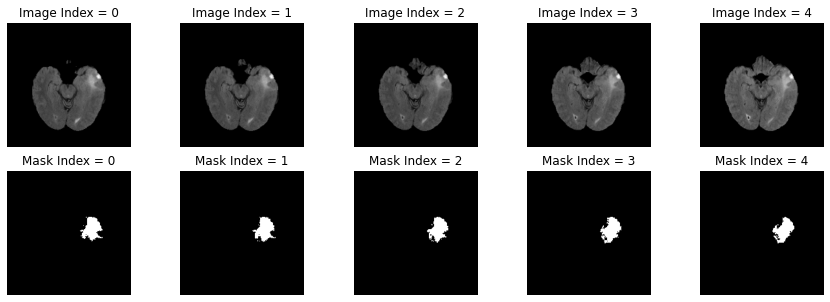

In [9]:
show_image(x, y, False)

# Training

## Define the model

In [10]:
def build_model(image_size=192):
    inputs = Input((image_size, image_size, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4= Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5= Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis = -1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6= Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(up6), conv3], axis = -1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7= Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(up7), conv2], axis = -1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8= Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(up8), conv1], axis = -1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9= Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10= Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)

    model.summary()
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model

## Splitting dataset

In [11]:
x_train, y_train, x_test, y_test = train_test_split(x, y, 0.9, image_size, seed)

Show First 5 images and masks


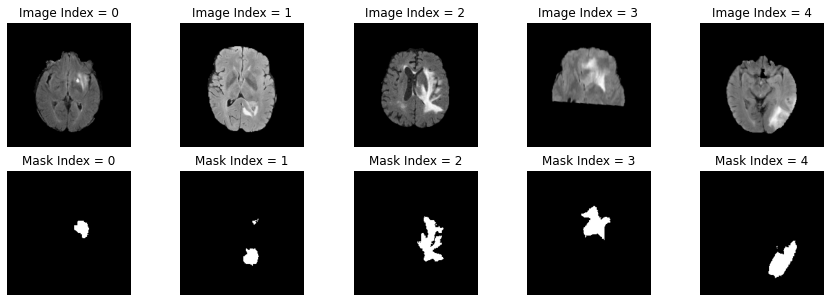

In [12]:
show_image(x_train, y_train, False)

## Model fitting

In [13]:
model = build_model(image_size)
history = model.fit(
        x_train, 
        y_train, 
        batch_size=16, 
        validation_split=0.2, 
        epochs = num_epoch, 
        verbose=1, 
        shuffle=True
)
model.save_weights('weights_{}_{}_seed{}.h5'.format(image_size, num_epoch, seed))
# model.load_weights('weights_{}_{}_seed{}.h5'.format(image_size, num_epoch, seed))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

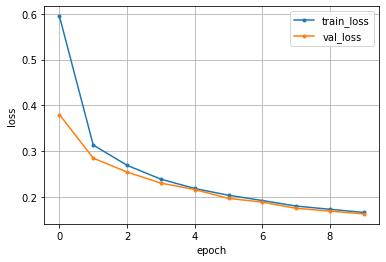

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(num_epoch), loss, marker='.', label='train_loss')
plt.plot(range(num_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation